In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import pathlib
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
data_dir = "/content/gdrive/My Drive/CSE382M/Photos"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive


In [3]:
# labels = os.listdir(data_dir)
# image_count = len(list(data_dir.glob('**/*.jpg')))
color = False

In [4]:
batch_size = 32
img_height = 256
img_width = 256
img_channels = 1
color_mode = "grayscale"
if color:
  img_channels = 3
  color_mode = "rgb"
  

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.9,
  subset="training",
  color_mode=color_mode,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31500 files belonging to 45 classes.
Using 3150 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=.04,
  subset="validation",
  color_mode=color_mode,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.09,
  subset="validation",
  color_mode=color_mode,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# TODO: Make all images grayscale with tf.ds something something...

Found 31500 files belonging to 45 classes.
Using 1260 files for validation.
Found 31500 files belonging to 45 classes.
Using 2835 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(4500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)
# layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
model = Sequential([
  layers.Conv2D(16, 5, padding='same', activation='relu', input_shape=(img_height, img_width, img_channels)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# TODO: 
# 1) and BN and/or dropout.
# 2) increase network depth

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        2

In [11]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
99/99 [==============================] - 17s 90ms/step - loss: 3.7619 - accuracy: 0.0422 - val_loss: 3.6266 - val_accuracy: 0.0492
Epoch 2/20
99/99 [==============================] - 6s 65ms/step - loss: 3.4646 - accuracy: 0.0844 - val_loss: 3.4612 - val_accuracy: 0.0889
Epoch 3/20
99/99 [==============================] - 7s 66ms/step - loss: 3.2458 - accuracy: 0.1330 - val_loss: 3.3112 - val_accuracy: 0.1056
Epoch 4/20
99/99 [==============================] - 6s 65ms/step - loss: 3.0566 - accuracy: 0.1702 - val_loss: 3.3397 - val_accuracy: 0.0992
Epoch 5/20
99/99 [==============================] - 6s 65ms/step - loss: 2.8867 - accuracy: 0.2244 - val_loss: 3.2865 - val_accuracy: 0.1397
Epoch 6/20
99/99 [==============================] - 6s 65ms/step - loss: 2.6917 - accuracy: 0.2657 - val_loss: 3.1961 - val_accuracy: 0.1452
Epoch 7/20
99/99 [==============================] - 6s 64ms/step - loss: 2.4743 - accuracy: 0.3156 - val_loss: 3.2863 - val_accuracy: 0.1333
Epoch 8/20
9

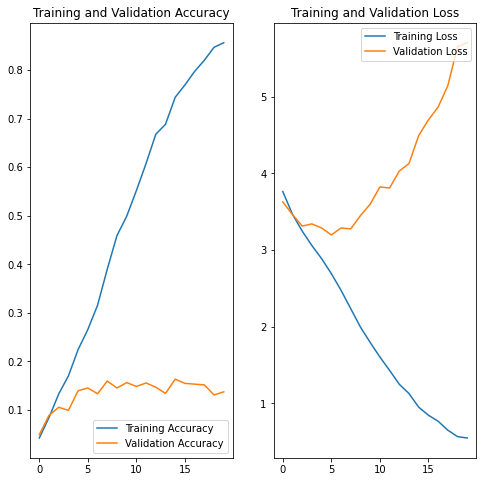

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()